# Section 3

In this section of tutorial, you will:
1. Load an unlabeled base dataset and an unlabeled target dataset
2. Access to some labels in the base dataset
3. Derive the calibration curve and class-conditional density function for base dataset
4. Extrapolate those two properties from base dataset to the target dataset, using PE and Mixture Model.

For the exercises, we ask you to rerun this code on a different dataset and answer the following questions:
1. Fill in columns H-K for datasets 1-4
2. Which sampling methods yield the smallest confidence intervals?
3. For which datasets does the choice of PE vs. MM make the most difference? Call this the uncertainty due to the stability assumption?
4. How does the uncertainty due to the choice of stability assumption compare to the uncertainty due to sample size and choice of sampling method

You should also fill in column H and K for dataset 1-4 in your copy of the [results spreadsheet]( https://docs.google.com/spreadsheets/d/10oEQR-_6px9sRF3cRiIPChiBcrWPVPy12TN7oHCA4qU), based on your findings from the notebook.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from util import plot_stacked_frequency
from util import DataHandler
from util import NPBinningCalibrationCurve, LogisticCalibrationCurve, ProbabilityEstimator, MixtureModelEstimator

## 1. Load a base dataset and a target dataset

In [2]:
# base is a very large dataset
base_dh = DataHandler('data/dataset5_base.csv')
target_dh = DataHandler('data/dataset5_target.csv')

In [3]:
# TODO: change the datasets
# base_dh = DataHandler('data/dataset2_target.csv')
# target_dh = DataHandler('data/dataset2_target.csv')

In [4]:
# you observe only classifier scores C(X), but no GT labels
base_dh.observed_df

,C(X),GT
0,0.254796,
1,0.888630,
2,0.815468,
3,0.801820,
4,0.209585,
...,...,...
99995,0.895500,
99996,0.392567,
99997,0.185034,
99998,0.891490,


## 2. distribution of classifier scores

Target is very different from base!

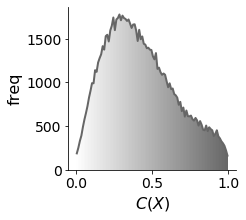

In [5]:
base_dh.plot_dist_classifier_scores()

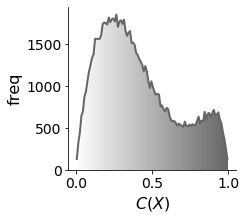

In [6]:
target_dh.plot_dist_classifier_scores()

## 3. Assume Stable calibration curve

### Repeat the code blocks below
=======================

Specify different sampling and n_item

### 3.1 Calibration phase: get a sample for annotation from base dataset

In [7]:
# remember to reset all oracle labels before each run
base_dh.hide_all_oracle()

In [8]:
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=500, strategy='random')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=500, strategy='uniform on C(X)')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='random')
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='uniform on C(X)')

In [9]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [10]:
base_dh.count_gt()

5000

In [11]:
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,True
4,0.209585,False
...,...,...
13215,0.677874,False
13221,0.617350,True
13228,0.663543,False
13246,0.653422,False


In [12]:
sample_df = base_dh.sample_df

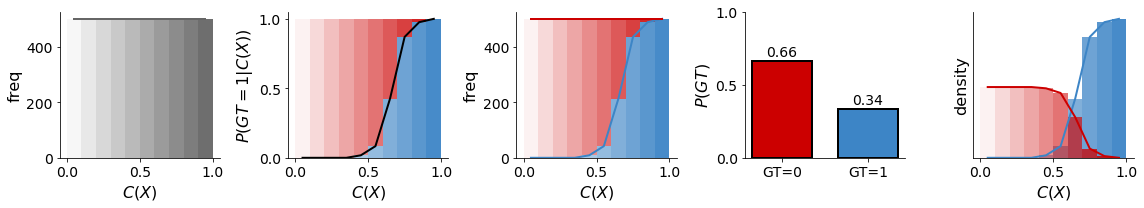

In [13]:
base_dh.generate_all_distribution_plots(df=sample_df, num_bin=10)

### 3.2 Get a calibration curve by Platt scaling

In [14]:
sample_calibration_curve = LogisticCalibrationCurve()
sample_calibration_curve.fit(sample_df)

### 3.3 Extrapolate the calibration curve to the target period

In [15]:
pe_estimator = ProbabilityEstimator()

pe_estimator.set_calibration_curve(sample_calibration_curve)

input_cx_array = target_dh.observed_df['C(X)'].values

pe_estimator.estimate(input_cx_array)

0.19608895731422024

### 3.4 Add bootstrap sampling for confidence interval

In [16]:
def extrinsic_bootstrap_estimating(input_cx_array, df, num_bootstrap, calibration_curve='platt scaling', verbose=False):
    # sample with replacement on the 5000 labeled df

    pe_estimator = ProbabilityEstimator()

    estimated_result_list = []

    for bootstrap_idx in range(num_bootstrap):
        n_item = len(df)
        bootstrapped_sample_df = df.sample(frac=1, replace=True)

        if calibration_curve == 'platt scaling':
            bootstrapped_calibration_curve = LogisticCalibrationCurve()
            bootstrapped_calibration_curve.fit(bootstrapped_sample_df)
        elif calibration_curve == 'nonparametric binning':
            bootstrapped_calibration_curve = NPBinningCalibrationCurve(bootstrapped_sample_df, num_bin=10)

        pe_estimator.set_calibration_curve(bootstrapped_calibration_curve)

        bootstrapped_pe_estimation = pe_estimator.estimate(input_cx_array)
        if verbose:
            print(f'bootstrap {bootstrap_idx+1:>3}: {bootstrapped_pe_estimation:.4f}')
        estimated_result_list.append(bootstrapped_pe_estimation)    
    return estimated_result_list

In [17]:
def get_median_CI(lst):
    return np.median(lst), np.percentile(lst, 2.5), np.percentile(lst, 97.5)

In [18]:
ps_estimated_result_list = extrinsic_bootstrap_estimating(target_dh.observed_df['C(X)'].values, 
                                                          sample_df, 
                                                          num_bootstrap=1000, 
                                                          calibration_curve='platt scaling', 
                                                          verbose=True)

bootstrap   1: 0.1949
bootstrap   2: 0.1977
bootstrap   3: 0.1954
bootstrap   4: 0.1965
bootstrap   5: 0.1941
bootstrap   6: 0.1955
bootstrap   7: 0.1971
bootstrap   8: 0.1945
bootstrap   9: 0.1965
bootstrap  10: 0.1970
bootstrap  11: 0.1961
bootstrap  12: 0.1936
bootstrap  13: 0.1938
bootstrap  14: 0.1990
bootstrap  15: 0.1931
bootstrap  16: 0.1922
bootstrap  17: 0.1920
bootstrap  18: 0.1962
bootstrap  19: 0.1961
bootstrap  20: 0.1940
bootstrap  21: 0.1982
bootstrap  22: 0.1980
bootstrap  23: 0.1930
bootstrap  24: 0.1983
bootstrap  25: 0.1965
bootstrap  26: 0.1932
bootstrap  27: 0.1966
bootstrap  28: 0.1931
bootstrap  29: 0.1955
bootstrap  30: 0.1942
bootstrap  31: 0.1981
bootstrap  32: 0.1957
bootstrap  33: 0.1972
bootstrap  34: 0.1990
bootstrap  35: 0.1982
bootstrap  36: 0.1967
bootstrap  37: 0.1965
bootstrap  38: 0.1932
bootstrap  39: 0.1940
bootstrap  40: 0.1986
bootstrap  41: 0.1949
bootstrap  42: 0.1931
bootstrap  43: 0.1947
bootstrap  44: 0.1974
bootstrap  45: 0.1924
bootstrap 

bootstrap 381: 0.1970
bootstrap 382: 0.1956
bootstrap 383: 0.1974
bootstrap 384: 0.1978
bootstrap 385: 0.1935
bootstrap 386: 0.1955
bootstrap 387: 0.1956
bootstrap 388: 0.1967
bootstrap 389: 0.1915
bootstrap 390: 0.1913
bootstrap 391: 0.1960
bootstrap 392: 0.1969
bootstrap 393: 0.1973
bootstrap 394: 0.1952
bootstrap 395: 0.1955
bootstrap 396: 0.1950
bootstrap 397: 0.1971
bootstrap 398: 0.1969
bootstrap 399: 0.1987
bootstrap 400: 0.1954
bootstrap 401: 0.1927
bootstrap 402: 0.1935
bootstrap 403: 0.1944
bootstrap 404: 0.1949
bootstrap 405: 0.1977
bootstrap 406: 0.1955
bootstrap 407: 0.1977
bootstrap 408: 0.1943
bootstrap 409: 0.1925
bootstrap 410: 0.2010
bootstrap 411: 0.1944
bootstrap 412: 0.1967
bootstrap 413: 0.1962
bootstrap 414: 0.1951
bootstrap 415: 0.2009
bootstrap 416: 0.1946
bootstrap 417: 0.1949
bootstrap 418: 0.1964
bootstrap 419: 0.1961
bootstrap 420: 0.1946
bootstrap 421: 0.1965
bootstrap 422: 0.1982
bootstrap 423: 0.1942
bootstrap 424: 0.1947
bootstrap 425: 0.1969
bootstrap 

bootstrap 769: 0.1968
bootstrap 770: 0.1975
bootstrap 771: 0.1907
bootstrap 772: 0.1975
bootstrap 773: 0.1946
bootstrap 774: 0.1946
bootstrap 775: 0.1995
bootstrap 776: 0.1996
bootstrap 777: 0.1953
bootstrap 778: 0.1970
bootstrap 779: 0.1967
bootstrap 780: 0.1943
bootstrap 781: 0.1960
bootstrap 782: 0.1986
bootstrap 783: 0.1988
bootstrap 784: 0.1957
bootstrap 785: 0.1928
bootstrap 786: 0.1959
bootstrap 787: 0.1973
bootstrap 788: 0.1932
bootstrap 789: 0.1958
bootstrap 790: 0.1953
bootstrap 791: 0.1945
bootstrap 792: 0.1932
bootstrap 793: 0.1967
bootstrap 794: 0.2017
bootstrap 795: 0.1968
bootstrap 796: 0.1952
bootstrap 797: 0.1944
bootstrap 798: 0.1941
bootstrap 799: 0.1953
bootstrap 800: 0.1942
bootstrap 801: 0.1977
bootstrap 802: 0.1940
bootstrap 803: 0.1989
bootstrap 804: 0.1937
bootstrap 805: 0.1942
bootstrap 806: 0.1940
bootstrap 807: 0.1943
bootstrap 808: 0.1969
bootstrap 809: 0.1972
bootstrap 810: 0.1941
bootstrap 811: 0.1979
bootstrap 812: 0.1954
bootstrap 813: 0.1940
bootstrap 

In [19]:
get_median_CI(ps_estimated_result_list)

(0.19600675278661917, 0.1923019258190659, 0.20020410972020586)

In [20]:
target_dh._p_gt

0.20031

=====================
### Repeat the code blocks above

## 4. Assume Stable class-conditional densities

### Repeat the code blocks below
=======================

Specify different sampling and n_item

## 4.1 Calibration phase: get a sample for annotation from base dataset

In [21]:
# remember to reset all oracle labels before each run
base_dh.hide_all_oracle()

In [22]:
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=500, strategy='random')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=500, strategy='uniform on C(X)')
# sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='random')
sampeld_rows = base_dh.get_sample_for_labeling(n_item=5000, strategy='uniform on C(X)')

In [23]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [24]:
base_dh.count_gt()

5000

In [25]:
base_dh.sample_df

,C(X),GT
0,0.254796,False
1,0.888630,True
2,0.815468,True
3,0.801820,True
4,0.209585,False
...,...,...
13215,0.677874,False
13221,0.617350,True
13228,0.663543,False
13246,0.653422,False


In [26]:
sample_df = base_dh.sample_df

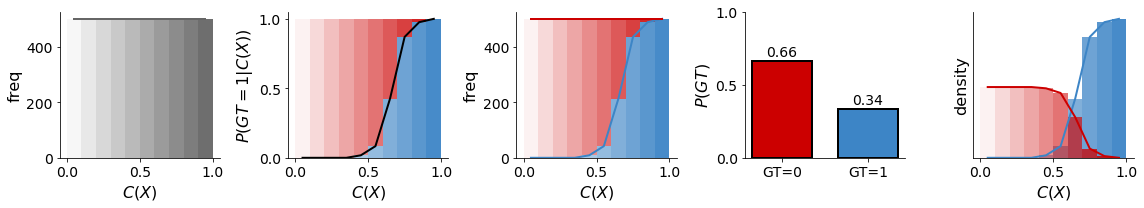

In [27]:
base_dh.generate_all_distribution_plots(df=sample_df, num_bin=10)

### 4.2 Get a calibration curve by Platt scaling

In [28]:
sample_calibration_curve = LogisticCalibrationCurve()
sample_calibration_curve.fit(sample_df)

### 4.3 Derive the class-conditional density functions in base dataset. We cannot use the class-conditional density function of sample_df directly, we have to recover the  class-conditional density function for base by inverse-weighting

In [29]:
sample_df = base_dh.sample_df
x_axis = np.linspace(0, 1, 11)

base_cx_hist, _ = np.histogram(base_dh.observed_df['C(X)'].values, bins=x_axis, density=True)
sample_cx_hist, _ = np.histogram(sample_df['C(X)'].values, bins=x_axis, density=True)

weight = base_cx_hist / sample_cx_hist

pos_cx = sample_df[sample_df['GT'] == True]['C(X)'].values
neg_cx = sample_df[sample_df['GT'] == False]['C(X)'].values

pos_hist_freq, _ = np.histogram(pos_cx, bins=x_axis, density=True)
neg_hist_freq, _ = np.histogram(neg_cx, bins=x_axis, density=True)

pos_hist_freq *= weight
pos_total = np.sum(pos_hist_freq)
pos_hist_freq /= pos_total

neg_hist_freq *= weight
neg_total = np.sum(neg_hist_freq)
neg_hist_freq /= neg_total

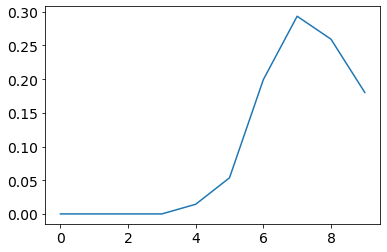

In [30]:
plt.plot(np.arange(10), pos_hist_freq)

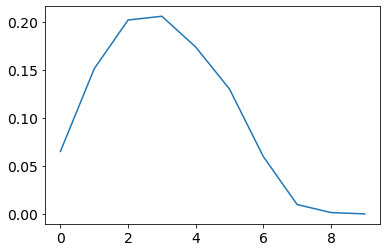

In [31]:
plt.plot(np.arange(10), neg_hist_freq)

In [32]:
mixture_model_estimator = MixtureModelEstimator()
mixture_model_estimator.fit(base_dh.sample_df, base_dh.observed_df['C(X)'].values, num_bin=10)

### 4.3 Extrapolate the calibration curve to the target period

In [33]:
mixture_model_estimator.estimate(target_dh.observed_df['C(X)'].values)

0.19

### 4.4 Add bootstrap sampling for confidence interval

In [34]:
def intrinsic_bootstrap_estimating(target_cx, sample_df, base_cx, num_bootstrap, verbose=False):
    estimated_result_list = []

    for bootstrap_idx in range(num_bootstrap):
        n_item = len(sample_df)
        bootstrapped_sample_df = sample_df.sample(frac=1, replace=True)
                    
        mixture_model_estimator = MixtureModelEstimator()
        mixture_model_estimator.fit(bootstrapped_sample_df, base_dh.observed_df['C(X)'].values, num_bin=10)
        
        bootstrapped_mm_estimation = mixture_model_estimator.estimate(target_cx)
        
        if verbose:
            print(f'bootstrap {bootstrap_idx+1:>3}: {bootstrapped_mm_estimation:.4f}')
        estimated_result_list.append(bootstrapped_mm_estimation)    
    return estimated_result_list

In [35]:
def get_median_CI(lst):
    return np.median(lst), np.percentile(lst, 2.5), np.percentile(lst, 97.5)

In [36]:
mm_estimated_result_list = intrinsic_bootstrap_estimating(target_dh.observed_df['C(X)'].values, 
                                                          sample_df=sample_df, 
                                                          base_cx=base_dh.observed_df['C(X)'].values,
                                                          num_bootstrap=1000, 
                                                          verbose=True)

bootstrap   1: 0.2000
bootstrap   2: 0.1900
bootstrap   3: 0.1900
bootstrap   4: 0.2000
bootstrap   5: 0.1900
bootstrap   6: 0.1900
bootstrap   7: 0.1900
bootstrap   8: 0.1900
bootstrap   9: 0.1900
bootstrap  10: 0.2000
bootstrap  11: 0.1900
bootstrap  12: 0.2000
bootstrap  13: 0.1900
bootstrap  14: 0.1900
bootstrap  15: 0.2000
bootstrap  16: 0.2000
bootstrap  17: 0.2000
bootstrap  18: 0.1900
bootstrap  19: 0.1900
bootstrap  20: 0.2000
bootstrap  21: 0.2000
bootstrap  22: 0.1900
bootstrap  23: 0.2000
bootstrap  24: 0.2000
bootstrap  25: 0.1900
bootstrap  26: 0.1900
bootstrap  27: 0.1900
bootstrap  28: 0.1900
bootstrap  29: 0.2000
bootstrap  30: 0.2000
bootstrap  31: 0.1900
bootstrap  32: 0.1900
bootstrap  33: 0.1900
bootstrap  34: 0.1900
bootstrap  35: 0.1900
bootstrap  36: 0.2000
bootstrap  37: 0.1900
bootstrap  38: 0.2000
bootstrap  39: 0.1900
bootstrap  40: 0.2000
bootstrap  41: 0.1900
bootstrap  42: 0.1900
bootstrap  43: 0.1900
bootstrap  44: 0.1900
bootstrap  45: 0.1900
bootstrap 

bootstrap 380: 0.1900
bootstrap 381: 0.1900
bootstrap 382: 0.2000
bootstrap 383: 0.1900
bootstrap 384: 0.1900
bootstrap 385: 0.1900
bootstrap 386: 0.1900
bootstrap 387: 0.1900
bootstrap 388: 0.1900
bootstrap 389: 0.1900
bootstrap 390: 0.1900
bootstrap 391: 0.2000
bootstrap 392: 0.2000
bootstrap 393: 0.1900
bootstrap 394: 0.1900
bootstrap 395: 0.1900
bootstrap 396: 0.1900
bootstrap 397: 0.1900
bootstrap 398: 0.1900
bootstrap 399: 0.1900
bootstrap 400: 0.2000
bootstrap 401: 0.1900
bootstrap 402: 0.1900
bootstrap 403: 0.1900
bootstrap 404: 0.1900
bootstrap 405: 0.1900
bootstrap 406: 0.1900
bootstrap 407: 0.2000
bootstrap 408: 0.2000
bootstrap 409: 0.2000
bootstrap 410: 0.2000
bootstrap 411: 0.1900
bootstrap 412: 0.1900
bootstrap 413: 0.1900
bootstrap 414: 0.1900
bootstrap 415: 0.1900
bootstrap 416: 0.1900
bootstrap 417: 0.1900
bootstrap 418: 0.1900
bootstrap 419: 0.1900
bootstrap 420: 0.1900
bootstrap 421: 0.2000
bootstrap 422: 0.1900
bootstrap 423: 0.1900
bootstrap 424: 0.1900
bootstrap 

bootstrap 757: 0.2000
bootstrap 758: 0.2000
bootstrap 759: 0.1900
bootstrap 760: 0.2000
bootstrap 761: 0.2000
bootstrap 762: 0.1900
bootstrap 763: 0.1900
bootstrap 764: 0.2000
bootstrap 765: 0.1900
bootstrap 766: 0.1900
bootstrap 767: 0.1900
bootstrap 768: 0.1900
bootstrap 769: 0.1900
bootstrap 770: 0.1900
bootstrap 771: 0.1900
bootstrap 772: 0.2000
bootstrap 773: 0.1900
bootstrap 774: 0.2000
bootstrap 775: 0.2000
bootstrap 776: 0.1900
bootstrap 777: 0.2000
bootstrap 778: 0.1900
bootstrap 779: 0.1900
bootstrap 780: 0.1900
bootstrap 781: 0.1900
bootstrap 782: 0.2000
bootstrap 783: 0.1900
bootstrap 784: 0.2000
bootstrap 785: 0.1900
bootstrap 786: 0.2000
bootstrap 787: 0.2000
bootstrap 788: 0.1900
bootstrap 789: 0.1900
bootstrap 790: 0.1900
bootstrap 791: 0.2000
bootstrap 792: 0.2000
bootstrap 793: 0.2000
bootstrap 794: 0.2000
bootstrap 795: 0.1900
bootstrap 796: 0.1900
bootstrap 797: 0.1900
bootstrap 798: 0.1900
bootstrap 799: 0.1900
bootstrap 800: 0.1900
bootstrap 801: 0.1900
bootstrap 

In [37]:
get_median_CI(mm_estimated_result_list)

(0.19, 0.19, 0.2)

In [38]:
target_dh._p_gt

0.20031

=====================
## Repeat the code blocks above